In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.stats import binom
import seaborn as sns

In [2]:
# define global constant
C = 100 # number of seats for coach
F = 20 # number of seats for first class
T = 365 # days until takeoff

In [3]:
overbook = 5

In [4]:
def book(overbook):
    
    O = overbook
    
    priceCL = 300 # low price for coach
    priceCH = 350 # high price for coach
    priceFL = 425 # low price for first class
    priceFH = 500 # high price for first class

    pCL = [0.35,0.65] # demand probabilities for coach low price
    pCH = [0.7,0.3] # demand probabilities for coach high price
    pFL = [0.92,0.08] # demand probabilities for first class low price
    pFH = [0.96,0.04] # demand probabilities for first class high price

    bumpL = 50 # cost to bump passenger to first class
    bumpH = 425 # cost to bump passenger off plane
    showC = 0.95 # probability of coach passenger showing up
    showF = 0.97 # probability of first class passenger showing up

    delta = 1/(1+0.15/365) # discount rate

    cValues = np.arange(C+O+1) # all possible number of coach seats left
    fValues = np.arange(F+1) # all possible number of first class seats left
    tValues = np.arange(T+1) # all possible days until takeoff

    cN = len(cValues) # count possible state values for coach seats
    fN = len(fValues) # count possible state values for first class seats
    tN = len(tValues) # count possible state values for time
    
    V = np.zeros((cN,fN,tN)) # initialize value function
    U = np.zeros((cN,fN,tN)) # initialize optimal choice variable
    
    # boundary/terminal condition
    U[:,:,tN-1] = 0 # 0 is the value for no tickets for sale

    # calculate cost
    for c in range(cN):
        for f in range(fN):
            total_cost = 0
            for i in range(c+1):
                for j in range(f+1):
                    if i > C:
                        extra_space = F-j
                        extra_passenger =  i-C
                        if extra_space < extra_passenger:
                            cost = (extra_passenger-extra_space)*bumpH + extra_space*bumpL
                        else:
                            cost = extra_passenger*bumpL
                        prob = binom.pmf(i,c,showC)*binom.pmf(j,f,showF)
                        total_cost += cost*prob   
            V[c,f,tN-1] = -(total_cost)
            
    for t in reversed(range(tN-1)): # loop backwards in time
        for c in range(cN): # loop over all possible coach seat values
            for f in range(fN): # loop over all possible first class seat values

                if c == cN-1 and f == fN-1: # if the coach seats and first class seats are full (0 seats left)
                    V[c,f,t] = delta*V[c,f,t+1] # if so, you can't make any more money
                    U[c,f,t] = 0 # no tickets for sale

                elif c == cN-1 and f < fN-1:
                    FL = (priceFL*pFL[1]) + delta*(pFL[1]*V[c,f+1,t+1] + pFL[0]*V[c,f,t+1])
                    FH = (priceFH*pFH[1]) + delta*(pFH[1]*V[c,f+1,t+1] + pFH[0]*V[c,f,t+1])
                    V[c,f,t] = max(FL, FH)
                    U[c,f,t] = np.argmax([FL, FH]) + 1 # choice of price: 1 means (0, L), 2 means (0, H)

                elif c < cN-1 and f == fN-1:
                    CL = (priceCL*pCL[1]) + delta*(pCL[1]*V[c+1,f,t+1] + pCL[0]*V[c,f,t+1])
                    CH = (priceCH*pCH[1]) + delta*(pCH[1]*V[c+1,f,t+1] + pCH[0]*V[c,f,t+1])
                    V[c,f,t] = max(CL, CH)
                    U[c,f,t] = np.argmax([CL, CH]) + 3 # choice of price: 3 means (L, 0), 4 means (H, 0)

                else:
                    CLFL = ((priceCL+priceFL)*pCL[1]*pFL[1]) + ((0+priceFL)*pCL[0]*pFL[1]) + \
                           ((priceCL+0)*pCL[1]*pFL[0]) + ((0+0)*pCL[0]*pFL[0]) + \
                            delta*((pCL[1]*pFL[1])*V[c+1,f+1,t+1]) + delta*((pCL[0]*pFL[1])*V[c,f+1,t+1]) + \
                            delta*((pCL[1]*pFL[0])*V[c+1,f,t+1]) + delta*((pCL[0]*pFL[0])*V[c,f,t+1]) 

                    CLFH = ((priceCL+priceFH)*pCL[1]*pFH[1]) + ((0+priceFH)*pCL[0]*pFH[1]) + \
                           ((priceCL+0)*pCL[1]*pFH[0]) + ((0+0)*pCL[0]*pFH[0]) + \
                            delta*((pCL[1]*pFH[1])*V[c+1,f+1,t+1]) + delta*((pCL[0]*pFH[1])*V[c,f+1,t+1]) + \
                            delta*((pCL[1]*pFH[0])*V[c+1,f,t+1]) + delta*((pCL[0]*pFH[0])*V[c,f,t+1])  

                    CHFL = ((priceCH+priceFL)*pCH[1]*pFL[1]) + ((0+priceFL)*pCH[0]*pFL[1]) + \
                           ((priceCH+0)*pCH[1]*pFL[0]) + ((0+0)*pCH[0]*pFL[0]) + \
                            delta*((pCH[1]*pFL[1])*V[c+1,f+1,t+1]) + delta*((pCH[0]*pFL[1])*V[c,f+1,t+1]) + \
                            delta*((pCH[1]*pFL[0])*V[c+1,f,t+1]) + delta*((pCH[0]*pFL[0])*V[c,f,t+1]) 

                    CHFH = ((priceCH+priceFH)*pCH[1]*pFH[1]) + ((0+priceFH)*pCH[0]*pFH[1]) + \
                           ((priceCH+0)*pCH[1]*pFH[0]) + ((0+0)*pCH[0]*pFH[0]) + \
                            delta*((pCH[1]*pFH[1])*V[c+1,f+1,t+1]) + delta*((pCH[0]*pFH[1])*V[c,f+1,t+1]) + \
                            delta*((pCH[1]*pFH[0])*V[c+1,f,t+1]) + delta*((pCH[0]*pFH[0])*V[c,f,t+1]) 

                    V[c,f,t] = max([CLFL,CLFH,CHFL,CHFH]) # value funciton maximizes expected revenue
                    U[c,f,t] = np.argmax([CLFL,CLFH,CHFL,CHFH]) +5 # choice of price: 5 means LL, 6 LH, 7 means HL, 8 means HH
                    
    profit = V[0,0,0]
    cost = V[c,f,tN-1]
    
    return profit, cost, U

In [5]:
profit, cost, U = book(overbook)
print('The profit is:',profit)
print('The cost is:',cost)

The profit is: 42242.862198795076
The cost is: -240.92770229606109


# Question 2

In [6]:
# determine list of overbook values
overbook_list = np.arange(6,16)

In [7]:
df = pd.DataFrame(columns = ['Overbook', 'Profit', 'Cost'])

for overbook in overbook_list:
    profit, cost, U = book(overbook)
    df = df.append({'Overbook': overbook, 'Profit': profit, 'Cost': cost}, ignore_index=True)

df

,Overbook,Profit,Cost
0,6.0,42368.868993,-434.289407
1,7.0,42444.241213,-690.358430
2,8.0,42482.211238,-998.676874
3,9.0,42496.112304,-1345.467811
4,10.0,42495.971957,-1717.685113
5,11.0,42488.259536,-2105.171140
6,12.0,42476.996209,-2501.071102
7,13.0,42464.597940,-2901.260598
8,14.0,42452.362210,-3303.487127
9,15.0,42440.944844,-3706.619973


In [8]:
print('Optimal Number to Overbook:',df['Overbook'][np.argmax(df['Profit'])])

Optimal Number to Overbook: 9.0


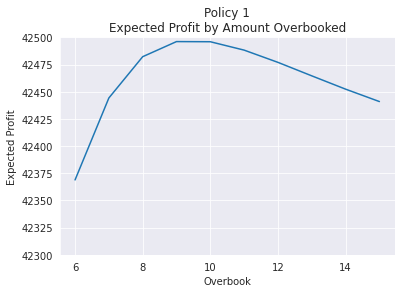

In [12]:
sns.set_style("darkgrid")
g = sns.lineplot(x = df["Overbook"], y = df["Profit"]).set(title = "Policy 1\nExpected Profit by Amount Overbooked", ylabel = "Expected Profit",ylim = (42300,42500))

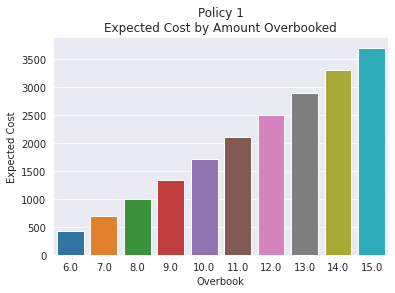

In [16]:
g = sns.barplot(x = df["Overbook"], y = -df["Cost"]).set(title = "Policy 1\nExpected Cost by Amount Overbooked", ylabel = "Expected Cost")

In [17]:
df['Cost Difference'] = -df['Cost'].diff()

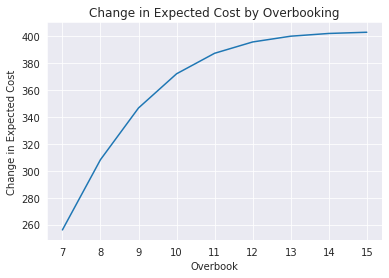

In [18]:
g = sns.lineplot(x = df["Overbook"], y = df["Cost Difference"]).set(title = "Change in Expected Cost by Overbooking", ylabel = "Change in Expected Cost")

# Question 3

In [ ]:
# define overbook limit
overbook = 20

In [ ]:
def book_new(overbook):
    
    O = overbook
    
    priceCL = 300 # low price for coach
    priceCH = 350 # high price for coach
    priceFL = 425 # low price for first class
    priceFH = 500 # high price for first class

    pCL = [0.35,0.65] # demand probabilities for coach low price
    pCH = [0.7,0.3] # demand probabilities for coach high price
    pFL = [0.92,0.08] # demand probabilities for first class low price
    pFH = [0.96,0.04] # demand probabilities for first class high price

    bumpL = 50 # cost to bump passenger to first class
    bumpH = 425 # cost to bump passenger off plane
    showC = 0.95 # probability of coach passenger showing up
    showF = 0.97 # probability of first class passenger showing up

    delta = 1/(1+0.15/365) # discount rate

    cValues = np.arange(C+O+1) # all possible number of coach seats left
    fValues = np.arange(F+1) # all possible number of first class seats left
    tValues = np.arange(T+1) # all possible days until takeoff

    cN = len(cValues) # count possible state values for coach seats
    fN = len(fValues) # count possible state values for first class seats
    tN = len(tValues) # count possible state values for time
    
    V = np.zeros((cN,fN,tN)) # initialize value function
    U = np.zeros((cN,fN,tN)) # initialize optimal choice variable
    
    # boundary/terminal condition
    U[:,:,tN-1] = 0 # 0 is the value for no tickets for sale

    # calculate cost
    for c in range(cN):
        for f in range(fN):
            total_cost = 0
            for i in range(c+1):
                for j in range(f+1):
                    if i > C:
                        extra_space = F-j
                        extra_passenger =  i-C
                        if extra_space < extra_passenger:
                            cost = (extra_passenger-extra_space)*bumpH + extra_space*bumpL
                        else:
                            cost = extra_passenger*bumpL
                        prob = binom.pmf(i,c,showC)*binom.pmf(j,f,showF)
                        total_cost += cost*prob   
            V[c,f,tN-1] = -(total_cost)
            
    for t in reversed(range(tN-1)): # loop backwards in time
        for c in range(cN): # loop over all possible coach seat values
            for f in range(fN): # loop over all possible first class seat values

                if c == cN-1 and f == fN-1: # if the coach seats and first class seats are full (0 seats left)
                    V[c,f,t] = delta*V[c,f,t+1] # if so, you can't make any more money
                    U[c,f,t] = 0 # no tickets for sale

                elif c == cN-1 and f < fN-1:
                    FL = (priceFL*pFL[1]) + delta*(pFL[1]*V[c,f+1,t+1] + pFL[0]*V[c,f,t+1])
                    FH = (priceFH*pFH[1]) + delta*(pFH[1]*V[c,f+1,t+1] + pFH[0]*V[c,f,t+1])
                    V[c,f,t] = max(FL, FH)
                    U[c,f,t] = np.argmax([FL, FH]) + 1 # choice of price: 1 means (0, L), 2 means (0, H) 

                elif c < cN-1 and f == fN-1:
                    CL = (priceCL*pCL[1]) + delta*(pCL[1]*V[c+1,f,t+1] + pCL[0]*V[c,f,t+1])
                    CH = (priceCH*pCH[1]) + delta*(pCH[1]*V[c+1,f,t+1] + pCH[0]*V[c,f,t+1])
                    CN = delta*V[c,f,t+1]
                    V[c,f,t] = max(CL, CH, CN)
                    U[c,f,t] = np.argmax([CL, CH, CN]) + 3 # choice of price: 3 means (L, 0), 4 means (H, 0), 5 means (N, 0)
                    
                else:
                    CLFL = ((priceCL+priceFL)*pCL[1]*pFL[1]) + ((0+priceFL)*pCL[0]*pFL[1]) + \
                           ((priceCL+0)*pCL[1]*pFL[0]) + ((0+0)*pCL[0]*pFL[0]) + \
                            delta*((pCL[1]*pFL[1])*V[c+1,f+1,t+1]) + delta*((pCL[0]*pFL[1])*V[c,f+1,t+1]) + \
                            delta*((pCL[1]*pFL[0])*V[c+1,f,t+1]) + delta*((pCL[0]*pFL[0])*V[c,f,t+1]) 

                    CLFH = ((priceCL+priceFH)*pCL[1]*pFH[1]) + ((0+priceFH)*pCL[0]*pFH[1]) + \
                           ((priceCL+0)*pCL[1]*pFH[0]) + ((0+0)*pCL[0]*pFH[0]) + \
                            delta*((pCL[1]*pFH[1])*V[c+1,f+1,t+1]) + delta*((pCL[0]*pFH[1])*V[c,f+1,t+1]) + \
                            delta*((pCL[1]*pFH[0])*V[c+1,f,t+1]) + delta*((pCL[0]*pFH[0])*V[c,f,t+1])  

                    CHFL = ((priceCH+priceFL)*pCH[1]*pFL[1]) + ((0+priceFL)*pCH[0]*pFL[1]) + \
                           ((priceCH+0)*pCH[1]*pFL[0]) + ((0+0)*pCH[0]*pFL[0]) + \
                            delta*((pCH[1]*pFL[1])*V[c+1,f+1,t+1]) + delta*((pCH[0]*pFL[1])*V[c,f+1,t+1]) + \
                            delta*((pCH[1]*pFL[0])*V[c+1,f,t+1]) + delta*((pCH[0]*pFL[0])*V[c,f,t+1]) 

                    CHFH = ((priceCH+priceFH)*pCH[1]*pFH[1]) + ((0+priceFH)*pCH[0]*pFH[1]) + \
                           ((priceCH+0)*pCH[1]*pFH[0]) + ((0+0)*pCH[0]*pFH[0]) + \
                            delta*((pCH[1]*pFH[1])*V[c+1,f+1,t+1]) + delta*((pCH[0]*pFH[1])*V[c,f+1,t+1]) + \
                            delta*((pCH[1]*pFH[0])*V[c+1,f,t+1]) + delta*((pCH[0]*pFH[0])*V[c,f,t+1])
                    
                    CNFH = priceFH*pFH[1] + delta*pFH[1]*V[c,f+1,t+1] + delta*pFH[0]*V[c,f,t+1]
                    
                    CNFL = priceFL*pFL[1] + delta*pFL[1]*V[c,f+1,t+1] + delta*pFL[0]*V[c,f,t+1]

                    V[c,f,t] = max([CLFL, CLFH, CHFL, CHFH, CNFH, CNFL]) # value funciton maximizes expected revenue
                    U[c,f,t] = np.argmax([CLFL,CLFH,CHFL,CHFH,CNFH,CNFL]) + 6 # choice of price: 6 LL, 7 LH, 8 HL, 9 HH, 10 NH, 11 NL
                    
    profit = V[0,0,0]
    cost = V[c,f,tN-1]
    
    return profit, cost, U

In [ ]:
profit, cost, U = book_new(overbook)
print('The profit is:',profit)
print('The cost is:',cost)

The profit is: 42502.673261243785
The cost is: -5725.001444450944


# Question 4

In [ ]:
def simulation1(overbook, U):
    
    U = U
    O = overbook
    
    priceCL = 300 # low price for coach
    priceCH = 350 # high price for coach
    priceFL = 425 # low price for first class
    priceFH = 500 # high price for first class

    pCL = [0.35,0.65] # demand probabilities for coach low price
    pCH = [0.7,0.3] # demand probabilities for coach high price
    pFL = [0.92,0.08] # demand probabilities for first class low price
    pFH = [0.96,0.04] # demand probabilities for first class high price

    bumpL = 50 # cost to bump passenger to first class
    bumpH = 425 # cost to bump passenger off plane
    showC = 0.95 # probability of coach passenger showing up
    showF = 0.97 # probability of first class passenger showing up

    delta = 1/(1+0.15/365) # discount rate

    cValues = np.arange(C+O+1) # all possible number of coach seats left
    fValues = np.arange(F+1) # all possible number of first class seats left
    tValues = np.arange(T+1) # all possible days until takeoff

    cN = len(cValues) # count possible state values for coach seats
    fN = len(fValues) # count possible state values for first class seats
    tN = len(tValues) # count possible state values for time
    
    c = 0 # coach tickets sold
    f = 0 # first class tickets sold

    showup_c = 0 # coach ticket buyers that show up
    showup_f = 0 # first class ticket buyers that show up
    
    total_rev = 0
    num_kickoff = 0
    
    for t in range(tN-1):
    
        optimal_price = U[c,f,t]
        
        if optimal_price == 0: # C no sale, F no sale
            prob_c = 0
            price_c = 0
            prob_f = 0
            price_f = 0
            
        elif optimal_price == 1: # C no sale, F low price
            prob_c = 0
            price_c = 0
            prob_f = pFL[1]
            price_f = priceFL

        elif optimal_price == 2: # C no sale, F high price
            prob_c = 0
            price_c = 0
            prob_f = pFH[1]
            price_f = priceFH
            
        elif optimal_price == 3: # C low price, F no sale
            prob_c = pCL[1]
            price_c = priceCL
            prob_f = 0
            price_f = 0
            
        elif optimal_price == 4: # C high price, F no sale
            prob_c = pCH[1]
            price_c = priceCH
            prob_f = 0
            price_f = 0
            
        elif optimal_price == 5: # C low price, F low sale
            prob_c = pCL[1]
            price_c = priceCL
            prob_f = pFL[1]
            price_f = priceFL
            
        elif optimal_price == 6: # C low price, F high sale
            prob_c = pCL[1]
            price_c = priceCL
            prob_f = pFH[1]
            price_f = priceFH
            
        elif optimal_price == 7: # C high price, F low sale
            prob_c = pCH[1]
            price_c = priceCH
            prob_f = pFL[1]
            price_f = priceFL
            
        else: # C high price, F high sale
            prob_c = pCH[1]
            price_c = priceCH
            prob_f = pFH[1]
            price_f = priceFH
            
        # is ticket sold?
        sale_c = (np.random.random(1) < prob_c) 
        sale_f = (np.random.random(1) < prob_f)

        total_rev += (sale_f*price_f + sale_c*price_c)*delta**(t)  # add up discounted revenues
        
        # did passenger show up?
        if sale_c == True:
            show_c = (np.random.random(1) < showC)
            showup_c = int(showup_c + show_c)
        if sale_f == True:
            show_f = (np.random.random(1) < showF)
            showup_f = int(showup_f + show_f)
        
        c = int(c+sale_c)  # total coach sold
        f = int(f+sale_f)  # total first class sold
        
    if showup_c > C:
        extra_space = F-showup_f
        extra_passenger = showup_c - C
        if extra_space < extra_passenger:
            cost = (extra_passenger-extra_space)*bumpH + extra_space*bumpL
            num_kickoff = extra_passenger-extra_space
        else:
            cost = extra_passenger*bumpL
            num_kickoff = extra_passenger
    else:
        cost = 0
        
    profit = total_rev - cost*delta
    
    return c, f, num_kickoff, total_rev, cost, profit

In [ ]:
nsim = 10000

overbook_vec_1 = np.array([False]*nsim)
kickoff_vec_1 = np.array([False]*nsim)
overbook_cost_vec_1 = np.zeros(nsim)
discount_profits_vec_1 = np.zeros(nsim)

overbook = df['Overbook'][np.argmax(df['Profit'])]
profit, cost, U = book(overbook)

for sim in range(nsim):
    c, f, num_kickoff, total_rev, total_cost, profit = simulation1(overbook, U)
    
    if c > C:
        overbook_vec_1[sim] = True
        
    if num_kickoff > 0:
        kickoff_vec_1[sim] = True
        
    overbook_cost_vec_1[sim] = total_cost
    
    discount_profits_vec_1[sim] = profit

In [ ]:
np.mean(overbook_cost_vec_1)

965.73

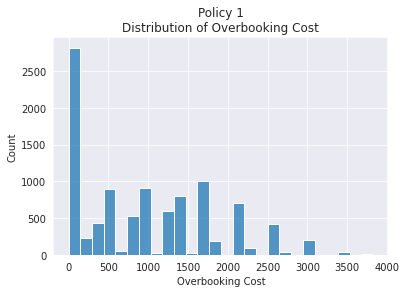

In [ ]:
g = sns.histplot(overbook_cost_vec_1).set(title = "Policy 1\nDistribution of Overbooking Cost", xlabel = "Overbooking Cost")

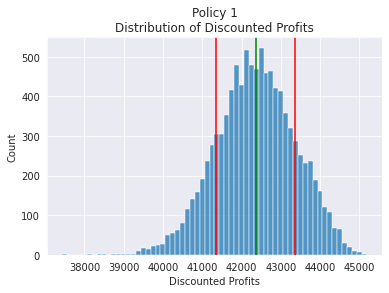

In [ ]:
g = sns.histplot(discount_profits_vec_1).set(title = "Policy 1\nDistribution of Discounted Profits", xlabel = "Discounted Profits")
plt.axvline(np.mean(discount_profits_vec_1), color='green')
plt.axvline(np.mean(discount_profits_vec_1) + np.std(discount_profits_vec_1) , color='red')
plt.axvline(np.mean(discount_profits_vec_1) - np.std(discount_profits_vec_1) , color='red')

In [ ]:
np.std(discount_profits_vec_1)

1004.9958875612853

In [ ]:
np.mean(discount_profits_vec_1)

42355.16156905784

In [ ]:
print("Percentage coach is overbooked: ", np.mean(overbook_vec_1))
print("Percentage someone is kicked off the plane: ", np.mean(kickoff_vec_1))

Percentage coach is overbooked:  1.0
Percentage someone is kicked off the plane:  0.8247


In [ ]:
overbook = 20

In [ ]:
def simulation2(overbook, U):
    
    U = U
    O = overbook
    
    priceCL = 300 # low price for coach
    priceCH = 350 # high price for coach
    priceFL = 425 # low price for first class
    priceFH = 500 # high price for first class

    pCL = [0.35,0.65] # demand probabilities for coach low price
    pCH = [0.7,0.3] # demand probabilities for coach high price
    pFL = [0.92,0.08] # demand probabilities for first class low price
    pFH = [0.96,0.04] # demand probabilities for first class high price

    bumpL = 50 # cost to bump passenger to first class
    bumpH = 425 # cost to bump passenger off plane
    showC = 0.95 # probability of coach passenger showing up
    showF = 0.97 # probability of first class passenger showing up

    delta = 1/(1+0.15/365) # discount rate

    cValues = np.arange(C+O+1) # all possible number of coach seats left
    fValues = np.arange(F+1) # all possible number of first class seats left
    tValues = np.arange(T+1) # all possible days until takeoff

    cN = len(cValues) # count possible state values for coach seats
    fN = len(fValues) # count possible state values for first class seats
    tN = len(tValues) # count possible state values for time
    
    c = 0 # coach tickets sold
    f = 0 # first class tickets sold

    showup_c = 0 # coach ticket buyers that show up
    showup_f = 0 # first class ticket buyers that show up
    
    total_rev = 0
    num_kickoff = 0
    
    for t in range(tN-1):
    
        optimal_price = U[c,f,t]
        
        if optimal_price == 0: # C no sale, F no sale
            prob_c = 0
            price_c = 0
            prob_f = 0
            price_f = 0
            
        elif optimal_price == 1: # C no sale, F low price
            prob_c = 0
            price_c = 0
            prob_f = pFL[1]
            price_f = priceFL

        elif optimal_price == 2: # C no sale, F high price
            prob_c = 0
            price_c = 0
            prob_f = pFH[1]
            price_f = priceFH
            
        elif optimal_price == 3: # C low price, F no sale
            prob_c = pCL[1]
            price_c = priceCL
            prob_f = 0
            price_f = 0
            
        elif optimal_price == 4: # C high price, F no sale
            prob_c = pCH[1]
            price_c = priceCH
            prob_f = 0
            price_f = 0
            
        elif optimal_price == 5: # C no sale, F no sale
            prob_c = 0
            price_c = 0
            prob_f = 0
            price_f = 0
            
        elif optimal_price == 6: # C low price, F low sale
            prob_c = pCL[1]
            price_c = priceCL
            prob_f = pFL[1]
            price_f = priceFL
            
        elif optimal_price == 7: # C low price, F high sale
            prob_c = pCL[1]
            price_c = priceCL
            prob_f = pFH[1]
            price_f = priceFH
            
        elif optimal_price == 8: # C high price, F low sale
            prob_c = pCH[1]
            price_c = priceCH
            prob_f = pFL[1]
            price_f = priceFL
            
        elif optimal_price == 9: # C high price, F high sale
            prob_c = pCH[1]
            price_c = priceCH
            prob_f = pFH[1]
            price_f = priceFH
            
        elif optimal_price == 10: # C no sale, F high price
            prob_c = 0
            price_c = 0
            prob_f = pFH[1]
            price_f = priceFH

        else: # C no sale, F low price
            prob_c = 0
            price_c = 0
            prob_f = pFL[1]
            price_f = priceFL
            
        # is ticket sold?
        sale_c = (np.random.random(1) < prob_c) 
        sale_f = (np.random.random(1) < prob_f)

        total_rev += (sale_f*price_f + sale_c*price_c)*delta**(t)  # add up discounted revenues
        
        # did passenger show up?
        if sale_c == True:
            show_c = (np.random.random(1) < showC)
            showup_c = int(showup_c + show_c)
        if sale_f == True:
            show_f = (np.random.random(1) < showF)
            showup_f = int(showup_f + show_f)
        
        c = int(c+sale_c)  # total coach sold
        f = int(f+sale_f)  # total first class sold
        
    if showup_c > C:
        extra_space = F-showup_f
        extra_passenger = showup_c - C
        if extra_space < extra_passenger:
            cost = (extra_passenger-extra_space)*bumpH + extra_space*bumpL
            num_kickoff = extra_passenger-extra_space
        else:
            cost = extra_passenger*bumpL
            num_kickoff = extra_passenger
    else:
        cost = 0
        
    profit = total_rev - cost*delta
    
    return c, f, num_kickoff, total_rev, cost, profit

In [ ]:
nsim = 10000

overbook_vec_2 = np.array([False]*nsim)
kickoff_vec_2 = np.array([False]*nsim)
overbook_cost_vec_2 = np.zeros(nsim)
discount_profits_vec_2 = np.zeros(nsim)

profit, cost, U = book_new(overbook)

for sim in range(nsim):
    c, f, num_kickoff, total_rev, total_cost, profit = simulation2(overbook, U)
    
    if c > C:
        overbook_vec_2[sim] = True
        
    if num_kickoff > 0:
        kickoff_vec_2[sim] = True
        
    overbook_cost_vec_2[sim] = total_cost
    
    discount_profits_vec_2[sim] = profit

In [ ]:
np.mean(overbook_cost_vec_2)

1005.31

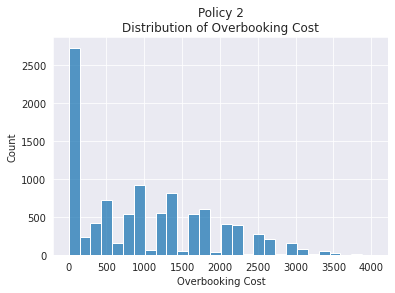

In [ ]:
g = sns.histplot(overbook_cost_vec_2).set(title = "Policy 2\nDistribution of Overbooking Cost", xlabel = "Overbooking Cost")


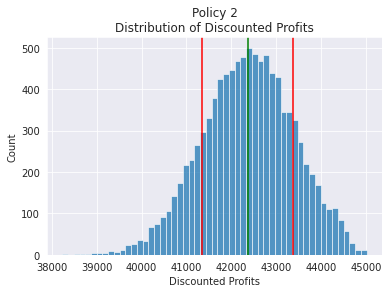

In [ ]:
g = sns.histplot(discount_profits_vec_2).set(title = "Policy 2\nDistribution of Discounted Profits", xlabel = "Discounted Profits")
plt.axvline(np.mean(discount_profits_vec_2), color='green')
plt.axvline(np.mean(discount_profits_vec_2) + np.std(discount_profits_vec_2) , color='red')
plt.axvline(np.mean(discount_profits_vec_2) - np.std(discount_profits_vec_2) , color='red')

In [ ]:
np.std(discount_profits_vec_2)

1018.0937944503106

In [ ]:
np.mean(discount_profits_vec_2)

42361.94959751489

In [ ]:
print("Percentage coach is overbooked: ", np.mean(overbook_vec_2))
print("Percentage someone is kicked off the plane: ", np.mean(kickoff_vec_2))

Percentage coach is overbooked:  1.0
Percentage someone is kicked off the plane:  0.8273
